In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot
import matplotlib

import sys
sys.path.append("../")

from analytics.classification_aux import em2_classification_cached
from classification import twopoisson_em
from analytics import visualization

from analytics.classification_aux import extract_train_test, print_results, compare_results
from aux.events_io import load_events, store_events
from classification.nhst_testing import *

##########################################

np.random.seed(123)

import logging
from imp import reload
reload(logging)
fmt = '[%(process)4d][%(asctime)s][%(levelname)-5s][%(module)s:%(lineno)d/%(funcName)s] %(message)s'
logging.basicConfig(format=fmt, level=logging.INFO, datefmt='%I:%M:%S')

%matplotlib inline

# RESEARCH ASSISTANT DATA PREPARATION

In [2]:
user2features = pd.read_csv("../../data/badges/covariates.tsv", sep="\t")
samples = pd.read_csv("../../data/badges_researchassistant.tsv", sep="\t")

In [3]:
NUM_TEST_USERS = 0 #!
city_features = ["c0", "c1", "c2", "c3", "c4"]
state_features = ["s0", "s1", "s2", "s3", "s4"]
user_features = ["age", "upvotes",  "views", "downvotes", "comments"]  
selected_features = user_features+city_features+state_features
features, train_ids, test_ids = extract_train_test(samples, user2features[["id"]+selected_features], 
                                                   max_test=NUM_TEST_USERS)

# Two-phase classification (EM2)

In [4]:
nhst_preds_file = "../../data/badges_researchassistant_nhst_preds.tsv" #intermediate results cache 

In [5]:
train_preds, test_preds, em2_results = em2_classification_cached(features, samples, train_ids, test_ids, 
                                                                   sigma=1, kappa=1,
                                                                   nhst_preds_file=nhst_preds_file)

[12278][08:48:19][INFO ][classification_aux:56/em2_classification_cached] NHST predictions loaded from ../../data/badges_researchassistant_nhst_preds.tsv
[12278][08:48:19][INFO ][classification_aux:78/em2_classification_cached] Clustering
[12278][08:48:19][INFO ][nhst_with_em2:83/nhst_classification] [nhst_with_em2][nhst_classification] >> NHST classification started.
[12278][08:48:19][INFO ][nhst_with_em2:125/two_step_classification] [two_step_classification] EM2 refining started.
[12278][08:48:20][INFO ][em2:165/normal_em] [em2][normal_em] iteration=0 ll=-697.344957136 prev_ll=None
[12278][08:48:20][INFO ][em2:165/normal_em] [em2][normal_em] iteration=1 ll=-608.809502851 prev_ll=-697.344957136
[12278][08:48:20][INFO ][em2:165/normal_em] [em2][normal_em] iteration=2 ll=-552.258187315 prev_ll=-608.809502851
[12278][08:48:20][INFO ][em2:165/normal_em] [em2][normal_em] iteration=3 ll=-494.86233164 prev_ll=-552.258187315
[12278][08:48:20][INFO ][em2:165/normal_em] [em2][normal_em] iterati

### Results visualization

In [6]:
print("available features:", list(enumerate(features.columns[1:])))

available features: [(0, 'age'), (1, 'upvotes'), (2, 'views'), (3, 'downvotes'), (4, 'comments'), (5, 'c0'), (6, 'c1'), (7, 'c2'), (8, 'c3'), (9, 'c4'), (10, 's0'), (11, 's1'), (12, 's2'), (13, 's3'), (14, 's4')]


In [7]:
#features to be plotted
features_no, features_names = zip(*[(0, 'age'), (2, 'views')]) 
#features_no, features_names = zip(*[(0, 'age'), (10, 's0')]) 
features_no, features_names = list(features_no), list(features_names)

/home/tomaszku/anaconda3/lib/python3.5/site-packages/matplotlib/contour.py:967: UserWarning: The following kwargs were not used by contour: 'lw'
  s)


train_preds0 = 35 = 0.56
train_preds1 = 27 = 0.44
test_preds0 = 0 = 0.00
test_preds1 = 0 = 0.00


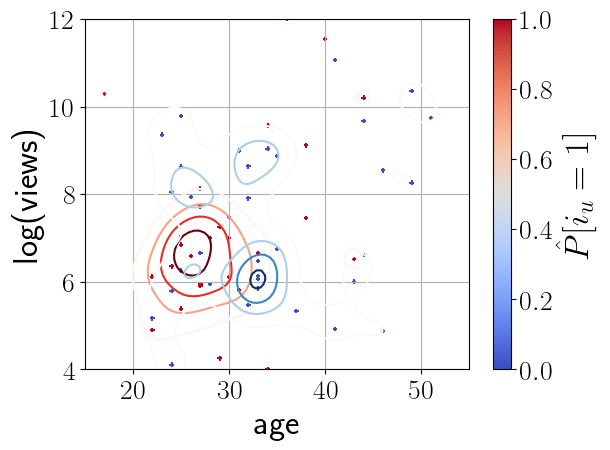

In [8]:
#PLOT NHST RESULTS
reload(visualization)

nhst_train_preds = em2_results["nhst_preds"]

visualization.pyplot_reset()
  
visualization.plot_groups(features, features_names, 
                          train_ids, nhst_train_preds, 
                          train_marker = "+", test_marker="x",
                          #ylabel="log(%s)" % features_names[1], 
                          plot_legend=False, s=10, plot_densities=True)

pyplot.gcf().subplots_adjust(bottom=0.15, left=0.15)# right=0.85, left=0.15)
pyplot.xlim((15,55)); pyplot.ylim((4,12)); pyplot.ylabel("log(%s)" % features_names[1])
#pyplot.xlim((15,55)); pyplot.ylim((1.75,3.75)); pyplot.ylabel("similarity to US")

visualization.pyplot_savefig("../../data/badges_researchassistant_nhst_preds0.pdf")

print_results(nhst_train_preds)

train_preds0 = 26 = 0.42
train_preds1 = 36 = 0.58
test_preds0 = 0 = 0.00
test_preds1 = 0 = 0.00


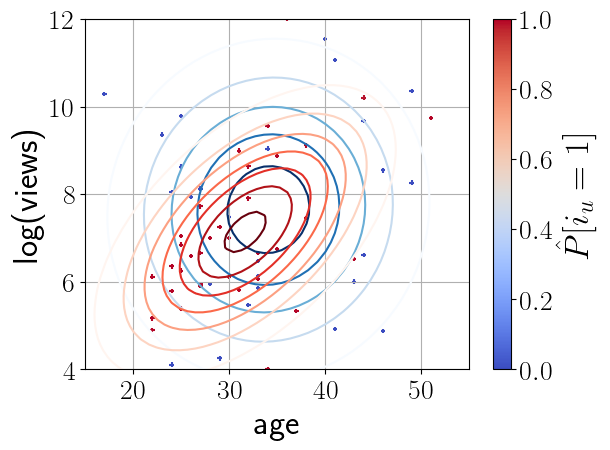

In [9]:
#PLOT FINAL RESULTS

visualization.pyplot_reset()
visualization.plot_groups(features, features_names, 
                          train_ids, train_preds, 
                          test_ids, test_preds,
                          train_marker = "+", test_marker="x",
                          #ylabel="log(%s)" % features_names[1], 
                          plot_legend=False, s=10, plot_densities=False)
visualization.plot_bivariate(em2_results["mu"][0,features_no], 
                             em2_results["ss"][0][np.ix_(features_no,features_no)], 
                             cmap="Blues")#, limits=(1,4,10,60))
visualization.plot_bivariate(em2_results["mu"][1,features_no], 
                             em2_results["ss"][1][np.ix_(features_no,features_no)], 
                             cmap="Reds")#, limits=(1,4,10,60))
#pyplot.xlim((1,4))

pyplot.gcf().subplots_adjust(bottom=0.15, left=0.15)# right=0.85, left=0.15)
pyplot.xlim((15,55)); pyplot.ylim((4,12)); pyplot.ylabel("log(%s)" % features_names[1])
#pyplot.xlim((15,55)); pyplot.ylim((1.75,3.75)); pyplot.ylabel("similarity to US")
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42 
matplotlib.rcParams['text.usetex'] = True
visualization.pyplot_savefig("../../data/badges_researchassistant_2sb_preds0.pdf")

print_results(train_preds, test_preds)

In [10]:
compare_results(nhst_train_preds, train_preds)


pearsonr= (0.54836801075320041, 3.9511547663135597e-06)
G: 24 23 12 3
p1= 0.43548387096774194 
p2= 0.5806451612903226
N= 62 
agreement= 0.758064516129
p-value= 0.0


/home/tomaszku/anaconda3/lib/python3.5/site-packages/matplotlib/contour.py:967: UserWarning: The following kwargs were not used by contour: 'lw'
  s)


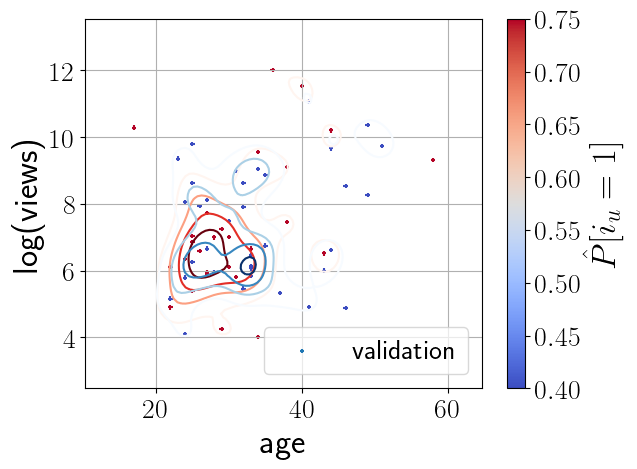

In [11]:
#PLOT INITIAL ASSIGNMENTS 
init_train_preds, init_test_preds = em2_results["init_train"], em2_results["init_test"]

visualization.pyplot_reset()
visualization.plot_groups(features, features_names, 
                          train_ids, init_train_preds, 
                          test_ids, init_test_preds, 
                          train_marker = "+", test_marker="x",
                          ylabel="log(%s)" % features_names[1], 
                          plot_legend=True, s=10, plot_densities=True)

## Features ranking

In [12]:
sfeature2states = {
"s0" : ['Lehi_UT', 'MISSION_VIEJO_CA', 'HOWELL_MI', 'EASTERN_OREGON', 'Mclean_VA', 'THOUSAND_OAKS_CA', 'NANTES_FRANCE', 'VENICE_FL', 'SOUTH_GEORGIA', 'NORTHWEST_FLORIDA'],
"s1" : ['India', 'NewDelhi', 'ndia', 'Rajathan', 'Inida', 'AHMEDABAD_INDIA', 'Sri_Lank', 'Ha_Noi_Viet_Nam', 'INdia', 'AHMADABAD'],
"s2" : ['Germany', 'Germnay', 'CzechRepublic', 'Belgium', 'Spain', 'Swizerland', 'France', 'Bussum', 'Weesp', 'Schijndel'],
"s3" : ['Russia', 'Romania', 'Poland', 'Ukraine', 'Czech_republic', 'CzechRepublic', 'Chişinău', 'Bulgaria', 'Lithuania', 'Hungary'],
"s4" : ['United_States', 'Curaçao_Netherlands_Antilles', 'Mclean_VA', 'NORTH_YORKSHIRE', 'Luleå_Sweden', 'OTTAWA_ONTARIO_CANADA', 'ANN_ARBOR_MICH', 'United_Kindom', 'Massachsetts', "XI'AN_CHINA"]
}

cfeature2cities = {
"c0" : ['Hyderabad', 'Bangalore', 'Chennai', 'Kolkata', 'Pune', 'Ahmedabad', 'Mumbai', 'Jaipur', 'Delhi', 'Lucknow'],
"c1" : ['Eching', 'Toruń', 'Zaltbommel', 'Zvenigorod', 'Deinze', 'Trenčín', 'Piatra_Neamt', 'Hradec_Králové', 'Zielona_Góra', 'Białystok'],
"c2" : ['Bento_Goncalves', 'Thiais', 'Torrejón_de_Ardoz', 'Eching', 'Melboune', 'Eaubonne', 'Phnom_Pehn', 'Bussum', 'London', 'Manises'],
"c3" : ['Shelby_Twp', 'CLINTON_TWP', 'HIDDEN_VALLEY_LAKE', 'PIKE_CREEK', 'FAIRVIEW_PARK', 'YALE_UNIVERSITY', 'MOON_TWP', 'RUTGERS_UNIVERSITY', 'ROUND_HILL', 'PUEBLO_WEST'],
"c4" : ['Philadlephia', 'Chicago', 'Los_Angeles', 'San_Francisco', 'Seatte', 'New_York', 'Wernau', 'San_Francicso', 'Seattle', 'LAKE_HUGHES']
}

f2f = {}
for sf, s in sfeature2states.items():
    f2f[sf] = "-".join(s[:3])
for cf, c in cfeature2cities.items():
    f2f[cf] = "-".join(c[:3])

In [13]:
KLs = []
for i in range(em2_results["ss"].shape[1]):
    m1 = em2_results["mu"][0,i]
    m2 = em2_results["mu"][1,i]    
    s1 = em2_results["ss"][0,i,i]
    s2 = em2_results["ss"][1,i,i]
    KL = np.log(s2/s1) + (s1**2+(m1-m2)**2)/(2*s2**2) - 1/2
    KLs.append((KL, m1>m2, features.columns[i+1]))
KLs = sorted(KLs)
    
for KL, positive, feature in KLs:
    #if feature.startswith("s") or  feature.startswith("c"): positive=not positive
    positive = "attracted" if positive else "don't care"
    print("%7s %s %s"  % (("%.2f" % KL), "%10s" % positive, f2f.get(feature, feature)))

   0.09  attracted age
   0.23  attracted upvotes
   0.26  attracted comments
   0.29  attracted views
   0.36  attracted Bento_Goncalves-Thiais-Torrejón_de_Ardoz
   0.43  attracted India-NewDelhi-ndia
   1.02  attracted Eching-Toruń-Zaltbommel
   1.36  attracted downvotes
   1.86  attracted Hyderabad-Bangalore-Chennai
   5.39  attracted United_States-Curaçao_Netherlands_Antilles-Mclean_VA
   7.65  attracted Germany-Germnay-CzechRepublic
  10.53 don't care Philadlephia-Chicago-Los_Angeles
  11.05  attracted Russia-Romania-Poland
  11.63 don't care Shelby_Twp-CLINTON_TWP-HIDDEN_VALLEY_LAKE
  17.39 don't care Lehi_UT-MISSION_VIEJO_CA-HOWELL_MI


# Poisson processes clustering (twopoisson_em)

In [14]:
train_preds2, test_preds2 = twopoisson_em.twopoisson_em_classification(features, samples, 
                                                                       train_ids, test_ids, 
                                                                       badge_name="switch_time")

[12278][08:48:31][INFO ][twopoisson_em:68/fitting] [twopoisson_em][em_fitting] TwoPoissonEMCOV fitting started.
/home/tomaszku/anaconda3/lib/python3.5/site-packages/scipy/optimize/_minimize.py:381: RuntimeWarning: Method COBYLA does not use gradient information (jac).
  RuntimeWarning)
/home/tomaszku/anaconda3/lib/python3.5/site-packages/scipy/optimize/cobyla.py:258: ComplexWarning: Casting complex values to real discards the imaginary part
  dinfo=info)
../clustering/poisson_ll.py:29: RuntimeWarning: invalid value encountered in log
  return (a*log(b) - (a+n)*log(lt+b) + loggamma(a+n) - loggamma(a) )
../clustering/twopoisson_em_with_covariates.py:190: ComplexWarning: Casting complex values to real discards the imaginary part
  self.z[u, 0] = np.exp(LL - logsumexp([LL, LL01]))
../clustering/twopoisson_em_with_covariates.py:191: ComplexWarning: Casting complex values to real discards the imaginary part
  self.z[u, 1] = np.exp(LL01 - logsumexp([LL, LL01]))
../clustering/twopoisson_em_wit

In [15]:
print_results(train_preds2, test_preds2)
compare_results(train_preds2, train_preds)
compare_results(test_preds2, test_preds)

train_preds0 = 36 = 0.58
train_preds1 = 26 = 0.42
test_preds0 = 0 = 0.00
test_preds1 = 0 = 0.00

pearsonr= (0.39349355172267453, 0.0015560990000458772)
G: 21 21 15 5
p1= 0.41935483870967744 
p2= 0.5806451612903226
N= 62 
agreement= 0.677419354839
p-value= 0.0013333333333333333


/home/tomaszku/anaconda3/lib/python3.5/site-packages/matplotlib/contour.py:967: UserWarning: The following kwargs were not used by contour: 'lw'
  s)


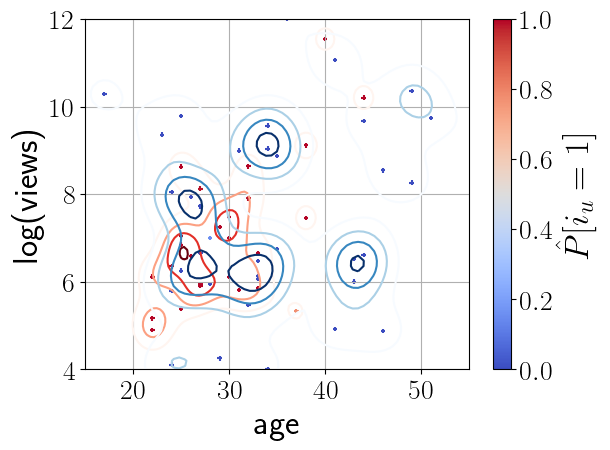

In [16]:
visualization.pyplot_reset()
visualization.plot_groups(features, features_names, 
                          train_ids, train_preds2,
                          test_ids, test_preds2,
                          train_marker = "+", test_marker="x",
                          plot_legend=False, s=10, plot_densities=True)

pyplot.gcf().subplots_adjust(bottom=0.15, left=0.15)# right=0.85, left=0.15)
pyplot.xlim((15,55)); pyplot.ylim((4,12)); pyplot.ylabel("log(%s)" % features_names[1])
#pyplot.xlim((15,55)); pyplot.ylim((1.75,3.75)); pyplot.ylabel("similarity to US")
visualization.pyplot_savefig("../../data/badges_researchassistant_2p_preds0.pdf")
